In [1]:
import os, shutil, pathlib
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2023-08-24 11:01:36.365390: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 11:01:36.405493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 11:01:36.968545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Create a smaller subset of dogs-vs-cats-db INTO training, validation, and test directories

In [2]:
original_dir = pathlib.Path('./dogs-vs-cats-db/train') # path to the directory where original dataset was uncompressed
new_base_dir = pathlib.Path('./cats_vs_dogs_small') # directory for our smaller dataset

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname, dst = dir / fname)

if not os.path.exists('./cats_vs_dogs_small'):
    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2500)

DATA AUGMENTATION NEEDED

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2023-08-24 11:01:38.822840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 11:01:38.838120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 11:01:38.838512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Setting up the architecture of the model

In [4]:
# model expects rgb images of size 180 x 180
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255) (x)#(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu") (x)
x = layers.Flatten() (x)
# augmentation
x = layers.Dropout(0.5) (x)

outputs = layers.Dense(1, activation="sigmoid") (x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
# model.summary()

In [6]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Use `image_dataset_from_directory(dir)` from Keras to read img into model

* list the subdirectories of `dir` and assumes each one contains images from one of the classes
* then index the image files in each subdirectory
* this creates and returns a `tf.data.Dataset` object, which is configured to...
> 1. read these files,
> 2. shuffle them,
> 3. decode them to tensors,
> 4. resize to shared size,
> 5. pack them into batches.

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [8]:
# displaying the shapes of the data and labels yielded by the 'Dataset' obj

for data_batch, labels_batch, in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.x",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [10]:
import nvidia.cudnn
print(nvidia.cudnn.__file__)

/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/nvidia/cudnn/__init__.py


In [11]:
# MODEL FIT into 'history'
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100


2023-08-24 11:01:41.621631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-24 11:01:42.219821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-24 11:01:42.220199: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1d70072db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-24 11:01:42.220217: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2023-08-24 11:01:42.222709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-24 11:01:42.278074: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

63/63 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.4960INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 11s 112ms/step - loss: 0.7001 - accuracy: 0.4960 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5065INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 82ms/step - loss: 0.6938 - accuracy: 0.5065 - val_loss: 0.6915 - val_accuracy: 0.5020
Epoch 3/100
62/63 [============================>.] - ETA: 0s - loss: 0.6914 - accuracy: 0.5292INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 73ms/step - loss: 0.6912 - accuracy: 0.5300 - val_loss: 0.6802 - val_accuracy: 0.5940
Epoch 4/100
62/63 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5731INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 85ms/step - loss: 0.6825 - accuracy: 0.5735 - val_loss: 0.6513 - val_accuracy: 0.6060
Epoch 5/100
63/63 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.6520INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 6s 89ms/step - loss: 0.6437 - accuracy: 0.6520 - val_loss: 0.6183 - val_accuracy: 0.6440
Epoch 6/100
62/63 [============================>.] - ETA: 0s - loss: 0.6204 - accuracy: 0.6598INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 4s 71ms/step - loss: 0.6193 - accuracy: 0.6615 - val_loss: 0.5992 - val_accuracy: 0.6520
Epoch 7/100
63/63 [==============================] - 4s 60ms/step - loss: 0.6053 - accuracy: 0.6780 - val_loss: 0.6124 - val_accuracy: 0.6480
Epoch 8/100
63/63 [==============================] - 4s 60ms/step - loss: 0.5988 - accuracy: 0.6830 - val_loss: 0.6038 - val_accuracy: 0.6560
Epoch 9/100
63/63 [==============================] - 4s 58ms/step - loss: 0.5951 - accuracy: 0.6840 - val_loss: 0.6709 - val_accuracy: 0.6420
Epoch 10/100
63/63 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.6985INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 11s 167ms/step - loss: 0.5868 - accuracy: 0.6985 - val_loss: 0.5898 - val_accuracy: 0.6860
Epoch 11/100
62/63 [============================>.] - ETA: 0s - loss: 0.5688 - accuracy: 0.7102INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 77ms/step - loss: 0.5686 - accuracy: 0.7110 - val_loss: 0.5647 - val_accuracy: 0.7020
Epoch 12/100
62/63 [============================>.] - ETA: 0s - loss: 0.5596 - accuracy: 0.7147INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 78ms/step - loss: 0.5594 - accuracy: 0.7145 - val_loss: 0.5559 - val_accuracy: 0.6900
Epoch 13/100
63/63 [==============================] - 4s 60ms/step - loss: 0.5478 - accuracy: 0.7280 - val_loss: 0.6039 - val_accuracy: 0.6920
Epoch 14/100
63/63 [==============================] - 4s 59ms/step - loss: 0.5315 - accuracy: 0.7410 - val_loss: 0.6347 - val_accuracy: 0.6900
Epoch 15/100
63/63 [==============================] - 4s 57ms/step - loss: 0.5229 - accuracy: 0.7370 - val_loss: 0.5600 - val_accuracy: 0.7290
Epoch 16/100
63/63 [==============================] - 4s 57ms/step - loss: 0.5192 - accuracy: 0.7295 - val_loss: 0.5914 - val_accuracy: 0.7040
Epoch 17/100
63/63 [==============================] - 4s 57ms/step - loss: 0.5085 - accuracy: 0.7500 - val_loss: 0.6665 - val_accuracy: 0.6920
Epoch 18/100
63/63 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.7530INFO:tensorflow:Assets written to: convnet_from_scratch_with

INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 76ms/step - loss: 0.5085 - accuracy: 0.7530 - val_loss: 0.5538 - val_accuracy: 0.7170
Epoch 19/100
63/63 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.7625INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 79ms/step - loss: 0.4908 - accuracy: 0.7625 - val_loss: 0.5221 - val_accuracy: 0.7460
Epoch 20/100
62/63 [============================>.] - ETA: 0s - loss: 0.4959 - accuracy: 0.7621INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 77ms/step - loss: 0.4961 - accuracy: 0.7615 - val_loss: 0.4902 - val_accuracy: 0.7600
Epoch 21/100
63/63 [==============================] - 4s 59ms/step - loss: 0.4686 - accuracy: 0.7800 - val_loss: 0.4931 - val_accuracy: 0.7530
Epoch 22/100
63/63 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.7755INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 11s 170ms/step - loss: 0.4694 - accuracy: 0.7755 - val_loss: 0.4855 - val_accuracy: 0.7860
Epoch 23/100
63/63 [==============================] - 4s 60ms/step - loss: 0.4347 - accuracy: 0.7955 - val_loss: 0.6438 - val_accuracy: 0.7480
Epoch 24/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4372 - accuracy: 0.7995 - val_loss: 0.5069 - val_accuracy: 0.7700
Epoch 25/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4405 - accuracy: 0.7915 - val_loss: 0.5183 - val_accuracy: 0.7830
Epoch 26/100
62/63 [============================>.] - ETA: 0s - loss: 0.4554 - accuracy: 0.7878INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 11s 170ms/step - loss: 0.4551 - accuracy: 0.7880 - val_loss: 0.4713 - val_accuracy: 0.7870
Epoch 27/100
63/63 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8065INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 75ms/step - loss: 0.4249 - accuracy: 0.8065 - val_loss: 0.4640 - val_accuracy: 0.7900
Epoch 28/100
63/63 [==============================] - ETA: 0s - loss: 0.4026 - accuracy: 0.8180INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 78ms/step - loss: 0.4026 - accuracy: 0.8180 - val_loss: 0.4549 - val_accuracy: 0.8140
Epoch 29/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4035 - accuracy: 0.8190 - val_loss: 0.4982 - val_accuracy: 0.7710
Epoch 30/100
63/63 [==============================] - 4s 59ms/step - loss: 0.3795 - accuracy: 0.8355 - val_loss: 0.6051 - val_accuracy: 0.7320
Epoch 31/100
62/63 [============================>.] - ETA: 0s - loss: 0.3806 - accuracy: 0.8352INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 10s 167ms/step - loss: 0.3810 - accuracy: 0.8350 - val_loss: 0.4353 - val_accuracy: 0.8240
Epoch 32/100
62/63 [============================>.] - ETA: 0s - loss: 0.4059 - accuracy: 0.8281INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 5s 80ms/step - loss: 0.4053 - accuracy: 0.8280 - val_loss: 0.3862 - val_accuracy: 0.8250
Epoch 33/100
63/63 [==============================] - 4s 58ms/step - loss: 0.3726 - accuracy: 0.8395 - val_loss: 0.5594 - val_accuracy: 0.7920
Epoch 34/100
63/63 [==============================] - 4s 58ms/step - loss: 0.3641 - accuracy: 0.8540 - val_loss: 0.4431 - val_accuracy: 0.8150
Epoch 35/100
63/63 [==============================] - 4s 58ms/step - loss: 0.3647 - accuracy: 0.8445 - val_loss: 0.4271 - val_accuracy: 0.8000
Epoch 36/100
63/63 [==============================] - 4s 58ms/step - loss: 0.3479 - accuracy: 0.8435 - val_loss: 0.5323 - val_accuracy: 0.7870
Epoch 37/100
63/63 [==============================] - 4s 59ms/step - loss: 0.3673 - accuracy: 0.8455 - val_loss: 0.4246 - val_accuracy: 0.8190
Epoch 38/100
63/63 [==============================] - 4s 55ms/step - loss: 0.3359 - accuracy: 0.8620 - val_loss: 0.4863 - val_accuracy: 0.7800
Epoch 39/100

INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 11s 171ms/step - loss: 0.2380 - accuracy: 0.9070 - val_loss: 0.3679 - val_accuracy: 0.8600
Epoch 65/100
63/63 [==============================] - 4s 61ms/step - loss: 0.2049 - accuracy: 0.9160 - val_loss: 0.4431 - val_accuracy: 0.8500
Epoch 66/100
63/63 [==============================] - 4s 59ms/step - loss: 0.1975 - accuracy: 0.9260 - val_loss: 0.6360 - val_accuracy: 0.8310
Epoch 67/100
63/63 [==============================] - 4s 58ms/step - loss: 0.2071 - accuracy: 0.9225 - val_loss: 0.4342 - val_accuracy: 0.8670
Epoch 68/100
63/63 [==============================] - 4s 58ms/step - loss: 0.1996 - accuracy: 0.9215 - val_loss: 0.7731 - val_accuracy: 0.8090
Epoch 69/100
63/63 [==============================] - 4s 60ms/step - loss: 0.2061 - accuracy: 0.9245 - val_loss: 0.3898 - val_accuracy: 0.8660
Epoch 70/100
63/63 [==============================] - 4s 59ms/step - loss: 0.1996 - accuracy: 0.9195 - val_loss: 0.4557 - val_accuracy: 0.8570
Epoch 71/1

Plot training accuracy vs validation accuracy

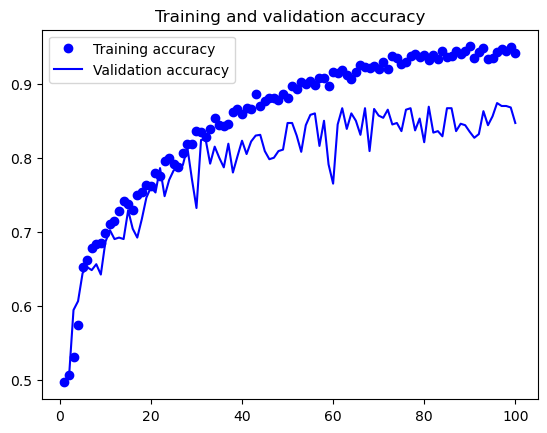

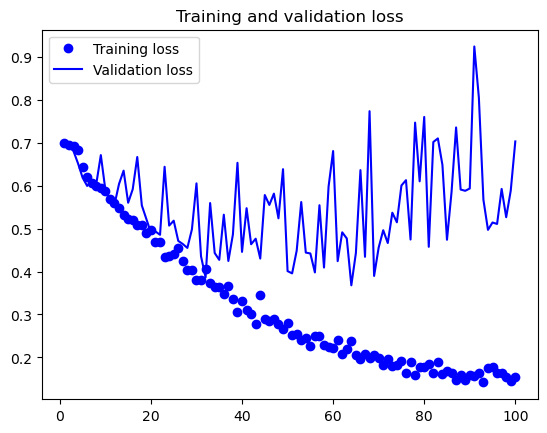

In [12]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

Evaluate model on test set

In [13]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 25ms/step - loss: 0.4564 - accuracy: 0.8420
Test accuracy: 0.842


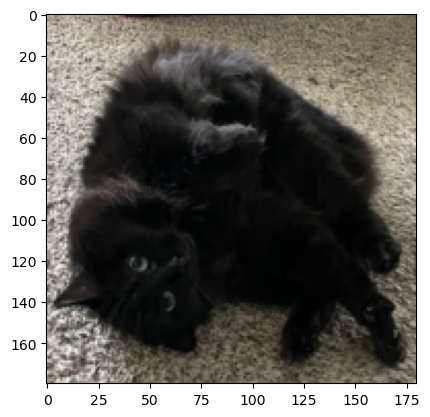

In [14]:
from PIL import Image

test_dog_path = './cats_vs_dogs_small/test/dog/dog.1507.jpg'
test_cat_path = './cats_vs_dogs_small/test/cat/cat.1500.jpg'
ivy = 'ivyBetter.png'
herbie = 'herbieSmall.png'

image = Image.open(ivy)

image = image.convert('RGB')
image = image.resize([180, 180])
plt.figure()
plt.imshow(image)

In [15]:
np_expanded_img = np.expand_dims(image, axis=0)
# img_scaled = np_expanded_img / 255.0

In [16]:
result = test_model.predict(np_expanded_img)
result

1/1 [==============================] - 0s 302ms/step


array([[0.00044017]], dtype=float32)

In [17]:
if result >= 0.5:
    print("THIS IS A VERY CUTE DOG :)")
else:
    print("THIS IS A VERY CUTE CAT :)")

THIS IS A VERY CUTE CAT :)
